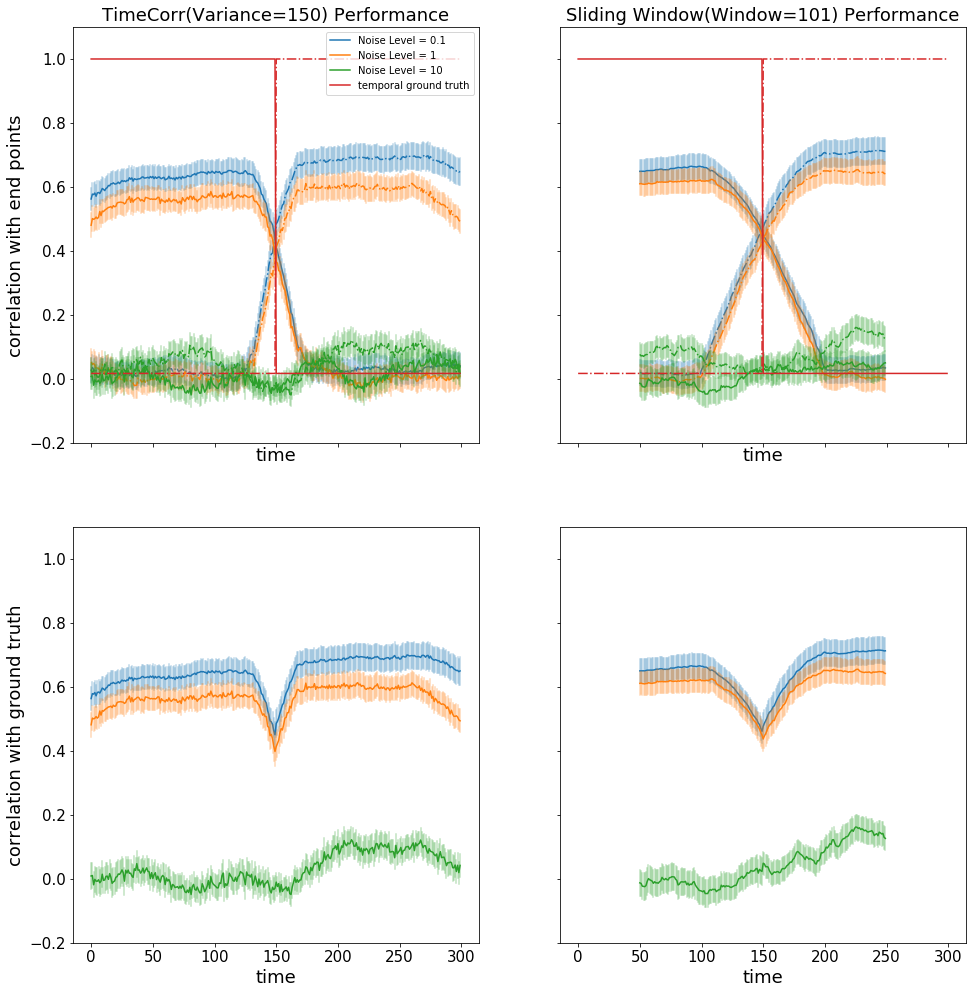

In [3]:
######## timecorr vs sliding window, different variances & ramp correlation
##### timecorr comparision with random guess, true correlations and sliding window isfc
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
from math import sqrt
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import isfc, sliding_window_isfc
import matplotlib.pyplot as plt
from math import log
variance = 150
sliding_window_length = 101
noise_level = [0.1,1,10]
repetitions=100
noise_num = len(noise_level)

block_length = 150
covariance_num = 2
time_len = block_length * covariance_num
activation_num = 5
subject_num = 5
activations = np.random.normal(0,1,[noise_num, subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
#     for i in range(time_len):
#         cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
#         correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
#         activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    correlations[0]=correlation1
    correlations[1]=correlation2
    activations_temp[:,:block_length]=np.dot(cholesky(correlation1),activations_temp[:,:block_length])
    activations_temp[:,block_length:]=np.dot(cholesky(correlation2),activations_temp[:,block_length:])

    for i in range(noise_num):
        activations[i]=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level[i],[subject_num, activation_num, time_len])



timecorr_correlations1,timecorr_correlations2 = np.zeros([repetitions,noise_num,time_len]),np.zeros([repetitions,noise_num,time_len])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros([repetitions,noise_num,time_len]),np.zeros([repetitions,noise_num,time_len])
true_correlations1,true_correlations2 = np.zeros([time_len]),np.zeros([time_len])

timecorr_correlations_single = np.zeros([repetitions,noise_num,time_len])
sliding_window_correlations_single = np.zeros([repetitions,noise_num,time_len])

color = ['b','r','k']

timecorr_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])
sliding_window_recovery = np.zeros([noise_num, time_len,(activation_num * (activation_num-1) / 2)])
true_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])
for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(noise_num):
        timecorr_recovery[v] = isfc(activations[v],variance)
        sliding_window_recovery[v,int(sliding_window_length/2):(time_len-int(sliding_window_length/2))] = sliding_window_isfc(activations[v],sliding_window_length)
    for t in range(time_len):
        true_recovery[t] = squareform(correlations[int(t/block_length)],checks=False)
    for timepoint in range(time_len):
        for v in range(noise_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[i,v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[i,v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint], true_recovery[timepoint])[0]
#             otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[timepoint/block_length],checks=False))[0]
            timecorr_correlations_single[i,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
        
            if timepoint>int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2):
                sc1 = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
                sliding_window_correlations1[i,v,timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
                sc2 = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
                sliding_window_correlations2[i,v,timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))
                swc = pearsonr(sliding_window_recovery[v,timepoint], true_recovery[timepoint])[0]
#                 swc = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlations[timepoint/block_length],checks=False))[0]
                sliding_window_correlations_single[i,v,timepoint] += 0.5 * (log(1+swc) - log(1-swc))

    
        tc1 = pearsonr(true_recovery[timepoint], squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(true_recovery[timepoint], squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))
           
timecorr_correlations1_std = np.std(timecorr_correlations1,0)/sqrt(repetitions)
timecorr_correlations1_std =  (np.exp(2*timecorr_correlations1_std) - 1)/(np.exp(2*timecorr_correlations1_std) + 1)
timecorr_correlations1 = np.mean(timecorr_correlations1,0)
# timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2_std = np.std(timecorr_correlations2,0)/sqrt(repetitions)
timecorr_correlations2_std =  (np.exp(2*timecorr_correlations2_std) - 1)/(np.exp(2*timecorr_correlations2_std) + 1)
timecorr_correlations2 = np.mean(timecorr_correlations2,0)
# timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1_std = np.std(sliding_window_correlations1,0)/sqrt(repetitions)
sliding_window_correlations1_std =  (np.exp(2*sliding_window_correlations1_std) - 1)/(np.exp(2*sliding_window_correlations1_std) + 1)
sliding_window_correlations1 = np.mean(sliding_window_correlations1,0)
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2_std = np.std(sliding_window_correlations2,0)/sqrt(repetitions)
sliding_window_correlations2_std =  (np.exp(2*sliding_window_correlations2_std) - 1)/(np.exp(2*sliding_window_correlations2_std) + 1)
sliding_window_correlations2 = np.mean(sliding_window_correlations2,0)
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
# timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single_std = np.std(sliding_window_correlations_single,0)/sqrt(repetitions)
sliding_window_correlations_single_std =  (np.exp(2*sliding_window_correlations_single_std) - 1)/(np.exp(2*sliding_window_correlations_single_std) + 1)
sliding_window_correlations_single = np.mean(sliding_window_correlations_single,0)
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 


f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharey='row',sharex='col', figsize=(16,16))
a1,a2= [ax1,ax2],[ax3,ax4]
plt.subplots_adjust(top=0.92)

# plt.suptitle("temporal ground truth linearly transforming from component A to component B over 500 timepoints",fontsize=20)
ax1.set_title("TimeCorr(Variance=150) Performance",fontsize=18)
ax2.set_title("Sliding Window(Window=101) Performance",fontsize=18)
# a1[2].set_title("variance = 1000, sliding window = 25",fontsize=18)
# a1[3].set_title("variance = 1500, sliding window = 25",fontsize=18)
ax1.set_ylabel("correlation with end points",fontsize=18)
ax3.set_ylabel("correlation with ground truth",fontsize=18)
for v in range(noise_num): 
    lower_limit, upper_limit = int(sliding_window_length/2),(time_len-int(sliding_window_length/2))
    ax1.plot(range(time_len),timecorr_correlations1[v],c='C'+str(v),linestyle='-',alpha=1.0, label = "Noise Level = "+str(noise_level[v]))
    ax1.plot(range(time_len),timecorr_correlations2[v],c='C'+str(v),linestyle='-.',alpha=1.0)

    ax2.plot(range(lower_limit,upper_limit),sliding_window_correlations1[v,lower_limit:upper_limit],c='C'+str(v),linestyle='-',alpha=1)
    ax2.plot(range(lower_limit,upper_limit),sliding_window_correlations2[v,lower_limit:upper_limit],c='C'+str(v),linestyle='-.',alpha=1)
    

    ax1.plot([range(time_len) for i in range(2)],[timecorr_correlations1[v]+timecorr_correlations1_std[v],timecorr_correlations1[v]-timecorr_correlations1_std[v]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax1.plot([range(time_len) for i in range(2)],[timecorr_correlations2[v]+timecorr_correlations2_std[v],timecorr_correlations2[v]-timecorr_correlations2_std[v]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax2.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations1[v,lower_limit:upper_limit]+sliding_window_correlations1_std[v,lower_limit:upper_limit],sliding_window_correlations1[v,lower_limit:upper_limit]-sliding_window_correlations1_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax2.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations2[v,lower_limit:upper_limit]+sliding_window_correlations2_std[v,lower_limit:upper_limit],sliding_window_correlations2[v,lower_limit:upper_limit]-sliding_window_correlations2_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.3)

    ax3.plot(range(time_len),timecorr_correlations_single[v],c='C'+str(v),alpha=1,linestyle='-')
    ax3.plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax4.plot([range(lower_limit,upper_limit) for i in range(2)],[sliding_window_correlations_single[v,lower_limit:upper_limit]+sliding_window_correlations_single_std[v,lower_limit:upper_limit],sliding_window_correlations_single[v,lower_limit:upper_limit]-sliding_window_correlations_single_std[v,lower_limit:upper_limit]],c='C'+str(v),linestyle='-',alpha=0.3)
    ax4.plot(range(lower_limit,upper_limit),sliding_window_correlations_single[v,lower_limit:upper_limit],c='C'+str(v),alpha=1,linestyle='-')
    ax3.set_xlabel("time",fontsize=18)
    ax3.tick_params(labelsize=15)
    ax4.set_xlabel("time",fontsize=18)
    ax4.tick_params(labelsize=15)
#     a2[v].tick_params(labelsize=15)

ax1.plot(range(time_len),true_correlations1,c='C'+str(v+1),linestyle='-',alpha=1,label = "temporal ground truth")
ax1.plot(range(time_len),true_correlations2,c='C'+str(v+1),linestyle='-.',alpha=1)
ax2.plot(range(time_len),true_correlations1,c='C'+str(v+1),linestyle='-',alpha=1,label = "temporal ground truth")
ax2.plot(range(time_len),true_correlations2,c='C'+str(v+1),linestyle='-.',alpha=1)

#     a2[v].set_xlabel("time",fontsize=18)
#     a2[v].tick_params(labelsize=15)
#     if v==var_num-1:

ax1.legend(loc='upper right')
ax1.set_ylim(-0.2, 1.1)
ax1.set_xlabel("time",fontsize=18)
ax1.tick_params(labelsize=15)

# ax2.legend(loc='upper right')
ax2.set_ylim(-0.2, 1.1)
ax2.set_xlabel("time",fontsize=18)
ax2.tick_params(labelsize=15)

# ax3.legend(loc='lower center')
ax3.set_ylim(-0.2, 1.1)
ax3.set_xlabel("time",fontsize=18)
ax3.tick_params(labelsize=15)

# ax4.legend(loc='lower center')
ax4.set_ylim(-0.2, 1.1)
ax4.set_xlabel("time",fontsize=18)
ax4.tick_params(labelsize=15)
        
plt.show()

In [ ]:
##### timecorr comparision with random guess, true correlations and sliding window isfc
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
from math import sqrt
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import isfc, sliding_window_isfc
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 51
block_length = 1
covariance_num = 300
noise_level = [0.1,1,10,100]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
activation_num = 6
subject_num = 5
variance = 300
activations = np.random.normal(0,1,[noise_num, subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level[i],[subject_num, activation_num, time_len])

timecorr_correlations1,timecorr_correlations2 = np.zeros([repetitions,noise_num,time_len]),np.zeros([repetitions,noise_num,time_len])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])
true_correlations1,true_correlations2 = np.zeros(time_len),np.zeros(time_len)
color = ['b','r','k']

timecorr_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])
sliding_window_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])
true_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])

timecorr_correlations_single = np.zeros([repetitions,noise_num,time_len])
sliding_window_correlations_single = np.zeros([noise_num,time_len])
random_correlations_single = np.zeros([noise_num,time_len])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(noise_num):
        timecorr_recovery[v] = isfc(activations[v],1000)
        sliding_window_recovery[v] = sliding_window_isfc(activations[v],sliding_window_length)
    for t in range(time_len):
        true_recovery[t] = squareform(correlations[t],checks=False)
    for timepoint in range(time_len):
        for v in range(noise_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[i,v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[i,v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
                        
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[timepoint],checks=False))[0]
            timecorr_correlations_single[i,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            if timepoint > int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2):
                sc1 = pearsonr(sliding_window_recovery[v,timepoint-int(sliding_window_length/2)], squareform(correlation1,checks=False))[0]
                sliding_window_correlations1[v,timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
                sc2 = pearsonr(sliding_window_recovery[v,timepoint-int(sliding_window_length/2)], squareform(correlation2,checks=False))[0]
                sliding_window_correlations2[v,timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))

                swc = pearsonr(sliding_window_recovery[v,timepoint-int(sliding_window_length/2)], squareform(correlations[timepoint],checks=False))[0]
                sliding_window_correlations_single[v,timepoint] += 0.5 * (log(1+swc) - log(1-swc))

        tc1 = pearsonr(true_recovery[timepoint], squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(true_recovery[timepoint], squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))

timecorr_correlations1_std = np.std(timecorr_correlations1,0)/sqrt(repetitions)
timecorr_correlations1_std =  (np.exp(2*timecorr_correlations1_std) - 1)/(np.exp(2*timecorr_correlations1_std) + 1)
timecorr_correlations1 = np.mean(timecorr_correlations1,0)
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2_std = np.std(timecorr_correlations2,0)/sqrt(repetitions)
timecorr_correlations2_std =  (np.exp(2*timecorr_correlations2_std) - 1)/(np.exp(2*timecorr_correlations2_std) + 1)
timecorr_correlations2 = np.mean(timecorr_correlations2,0)
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 
random_correlations_single /= repetitions
random_correlations_single =(np.exp(2*random_correlations_single) - 1)/(np.exp(2*random_correlations_single) + 1) 


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
# plt.subplots_adjust(top=0.95)
# plt.suptitle("temporal ground truth linearly transforming from component A to component B over 300 timepoints, with different levels of noise",fontsize=20)
a1[0].set_title("noise = 0.1",fontsize=18)
a1[1].set_title("noise = 1",fontsize=18)
a1[2].set_title("noise = 10",fontsize=18)
a1[3].set_title("noise = 100",fontsize=18)
a1[0].set_ylabel("ramping correlation",fontsize=18)
a2[0].set_ylabel("correlation with ground truth",fontsize=18)
for v in range(noise_num): 
    a1[v].plot(range(time_len),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A")
    a1[v].plot(range(time_len),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1[v,sliding_window_length/2:int(time_len-sliding_window_length/2)],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2[v,sliding_window_length/2:int(time_len-sliding_window_length/2)],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a1[v].plot(range(time_len),true_correlations1,c=color[0],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component A")
    a1[v].plot(range(time_len),true_correlations2,c=color[1],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component B")
    a1[v].set_xlabel("time",fontsize=18)
#     if v==noise_num-1:
#         a1[v].legend(bbox_to_anchor=(2, 1), loc=1)
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations1[v]+timecorr_correlations1_std[v],timecorr_correlations1[v]-timecorr_correlations1_std[v]],c=color[0],linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations2[v]+timecorr_correlations2_std[v],timecorr_correlations2[v]-timecorr_correlations2_std[v]],c=color[1],linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")
    a2[v].plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='r',linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")

    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations_single[v,sliding_window_length/2:int(time_len-sliding_window_length/2)],c='C1',alpha=0.5,linestyle='--')
    a2[v].set_xlabel("time",fontsize=18)
#     if v==noise_num-1:
#         a3[v].legend(bbox_to_anchor=(2, 1), loc=1)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)
plt.show()

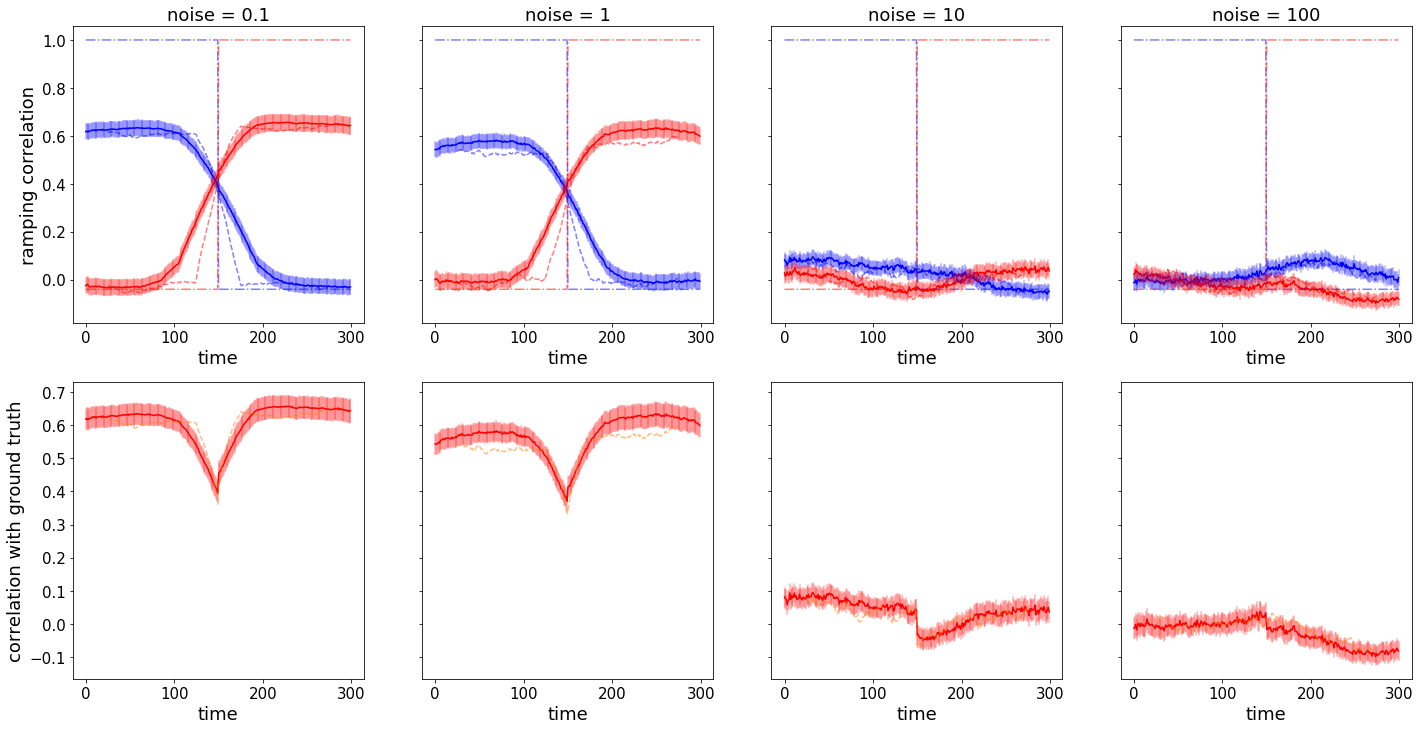

In [6]:
##### timecorr comparision with random guess, true correlations and sliding window isfc
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import isfc, sliding_window_isfc
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 51
block_length = 150
covariance_num = 2
noise_level = [0.1,1,10,100]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
activation_num = 6
subject_num = 5
variance = 100
activations = np.random.normal(0,1,[noise_num, subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
#     for i in range(covariance_num):
#         correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
#         activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    activations_temp[:,:block_length]=np.dot(cholesky(correlation1),activations_temp[:,:block_length])
    activations_temp[:,block_length:]=np.dot(cholesky(correlation2),activations_temp[:,block_length:])
    
    for i in range(noise_num):
        activations[i]=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level[i],[subject_num, activation_num, time_len])

timecorr_correlations1,timecorr_correlations2 = np.zeros([repetitions,noise_num,time_len]),np.zeros([repetitions,noise_num,time_len])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])
true_correlations1,true_correlations2 = np.zeros(time_len),np.zeros(time_len)
color = ['b','r','k']

timecorr_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])
sliding_window_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])
true_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])

timecorr_correlations_single = np.zeros([repetitions,noise_num,time_len])
sliding_window_correlations_single = np.zeros([noise_num,time_len])
random_correlations_single = np.zeros([noise_num,time_len])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(noise_num):
        timecorr_recovery[v] = isfc(activations[v],1000)
        sliding_window_recovery[v] = sliding_window_isfc(activations[v],sliding_window_length)
    for t in range(time_len/2):
        true_recovery[t] = squareform(correlation1,checks=False)
    for t in range(time_len/2,time_len):
        true_recovery[t] = squareform(correlation2,checks=False)
    for timepoint in range(time_len):
        for v in range(noise_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[i,v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[i,v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
                        
            otcs = pearsonr(timecorr_recovery[v, timepoint], true_recovery[timepoint])[0]
            timecorr_correlations_single[i,v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            if timepoint > int(sliding_window_length/2)-1 and timepoint<time_len-int(sliding_window_length/2):
                sc1 = pearsonr(sliding_window_recovery[v,timepoint-int(sliding_window_length/2)], squareform(correlation1,checks=False))[0]
                sliding_window_correlations1[v,timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
                sc2 = pearsonr(sliding_window_recovery[v,timepoint-int(sliding_window_length/2)], squareform(correlation2,checks=False))[0]
                sliding_window_correlations2[v,timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))

                swc = pearsonr(sliding_window_recovery[v,timepoint-int(sliding_window_length/2)], true_recovery[timepoint])[0]
                sliding_window_correlations_single[v,timepoint] += 0.5 * (log(1+swc) - log(1-swc))

        tc1 = pearsonr(true_recovery[timepoint], squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(true_recovery[timepoint], squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))

timecorr_correlations1_std = np.std(timecorr_correlations1,0)/sqrt(repetitions)
timecorr_correlations1_std =  (np.exp(2*timecorr_correlations1_std) - 1)/(np.exp(2*timecorr_correlations1_std) + 1)
timecorr_correlations1 = np.mean(timecorr_correlations1,0)
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2_std = np.std(timecorr_correlations2,0)/sqrt(repetitions)
timecorr_correlations2_std =  (np.exp(2*timecorr_correlations2_std) - 1)/(np.exp(2*timecorr_correlations2_std) + 1)
timecorr_correlations2 = np.mean(timecorr_correlations2,0)
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

timecorr_correlations_single_std = np.std(timecorr_correlations_single,0)/sqrt(repetitions)
timecorr_correlations_single_std =  (np.exp(2*timecorr_correlations_single_std) - 1)/(np.exp(2*timecorr_correlations_single_std) + 1)
timecorr_correlations_single = np.mean(timecorr_correlations_single,0)
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 
random_correlations_single /= repetitions
random_correlations_single =(np.exp(2*random_correlations_single) - 1)/(np.exp(2*random_correlations_single) + 1) 


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharey='row', figsize=(24,12))
a1,a2 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
# plt.subplots_adjust(top=0.95)
# plt.suptitle("temporal ground truth linearly transforming from component A to component B over 300 timepoints, with different levels of noise",fontsize=20)
a1[0].set_title("noise = 0.1",fontsize=18)
a1[1].set_title("noise = 1",fontsize=18)
a1[2].set_title("noise = 10",fontsize=18)
a1[3].set_title("noise = 100",fontsize=18)
a1[0].set_ylabel("ramping correlation",fontsize=18)
a2[0].set_ylabel("correlation with ground truth",fontsize=18)
for v in range(noise_num): 
    a1[v].plot(range(time_len),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A")
    a1[v].plot(range(time_len),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    a1[v].plot(range(sliding_window_length/2,int(time_len-sliding_window_length/2)),sliding_window_correlations1[v,sliding_window_length/2:int(time_len-sliding_window_length/2)],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a1[v].plot(range(sliding_window_length/2,int(time_len-sliding_window_length/2)),sliding_window_correlations2[v,sliding_window_length/2:int(time_len-sliding_window_length/2)],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a1[v].plot(range(time_len),true_correlations1,c=color[0],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component A")
    a1[v].plot(range(time_len),true_correlations2,c=color[1],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component B")
    a1[v].set_xlabel("time",fontsize=18)
#     if v==noise_num-1:
#         a1[v].legend(bbox_to_anchor=(2, 1), loc=1)
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations1[v]+timecorr_correlations1_std[v],timecorr_correlations1[v]-timecorr_correlations1_std[v]],c=color[0],linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")
    a1[v].plot([range(time_len) for i in range(2)],[timecorr_correlations2[v]+timecorr_correlations2_std[v],timecorr_correlations2[v]-timecorr_correlations2_std[v]],c=color[1],linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")
    a2[v].plot([range(time_len) for i in range(2)],[timecorr_correlations_single[v]+timecorr_correlations_single_std[v],timecorr_correlations_single[v]-timecorr_correlations_single_std[v]],c='r',linestyle='-',alpha=0.3, label = "timecorr recovery wrt component A")

    a2[v].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a2[v].plot(range(sliding_window_length/2,int(time_len-sliding_window_length/2)),sliding_window_correlations_single[v,sliding_window_length/2:int(time_len-sliding_window_length/2)],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a2[v].set_xlabel("time",fontsize=18)
#     if v==noise_num-1:
#         a3[v].legend(bbox_to_anchor=(2, 1), loc=1)
    a1[v].tick_params(labelsize=15)
    a2[v].tick_params(labelsize=15)
plt.show()